#### Downloading the web traffic time series data from kaggle & unzipping it.
#### https://www.kaggle.com/c/web-traffic-time-series-forecasting

In [1]:
import kaggle

! kaggle competitions download -c web-traffic-time-series-forecasting -p D:\kaggle\data\web-traffic

In [2]:
! unzip 'D:\kaggle\data\web-traffic\web-traffic-time-series-forecasting.zip' -d 'D:\kaggle\data\web-traffic'

Archive:  D:\kaggle\data\web-traffic\web-traffic-time-series-forecasting.zip
  inflating: D:\kaggle\data\web-traffic/key_1.csv.zip  
  inflating: D:\kaggle\data\web-traffic/key_2.csv.zip  
  inflating: D:\kaggle\data\web-traffic/sample_submission_1.csv.zip  
  inflating: D:\kaggle\data\web-traffic/sample_submission_2.csv.zip  
  inflating: D:\kaggle\data\web-traffic/train_1.csv.zip  
  inflating: D:\kaggle\data\web-traffic/train_2.csv.zip  


#### Import the standard libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
data = pd.read_csv(r"D:\kaggle\data\web-traffic\train_1.csv.zip")
data.head()

Page  2015-07-01  2015-07-02  \
0            2NE1_zh.wikipedia.org_all-access_spider        18.0        11.0   
1             2PM_zh.wikipedia.org_all-access_spider        11.0        14.0   
2              3C_zh.wikipedia.org_all-access_spider         1.0         0.0   
3         4minute_zh.wikipedia.org_all-access_spider        35.0        13.0   
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...         NaN         NaN   

   2015-07-03  2015-07-04  2015-07-05  2015-07-06  2015-07-07  2015-07-08  \
0         5.0        13.0        14.0         9.0         9.0        22.0   
1        15.0        18.0        11.0        13.0        22.0        11.0   
2         1.0         1.0         0.0         4.0         0.0         3.0   
3        10.0        94.0         4.0        26.0        14.0         9.0   
4         NaN         NaN         NaN         NaN         NaN         NaN   

   2015-07-09  ...  2016-12-22  2016-12-23  2016-12-24  2016-12-25  \
0        26.0  ...        32.0        63.0        15.0        26.0   
1        10.0  ...        17.0        42.0        28.0        15.0   
2         4.0  ...         3.0         1.0         1.0         7.0   
3        11.0  ...        32.0        10.0        26.0        27.0   
4         NaN  ...        48.0         9.0        25.0        13.0   

   2016-12-26  2016-12-27  2016-12-28  2016-12-29  2016-12-30  2016-12-31  
0        14.0        20.0        22.0        19.0        18.0        20.0  
1         9.0        30.0        52.0        45.0        26.0        20.0  
2         4.0         4.0         6.0         3.0         4.0        17.0  
3        16.0        11.0        17.0        19.0        10.0        11.0  
4         3.0        11.0        27.0        13.0        36.0        10.0  

[5 rows x 551 columns]

In [5]:
data.shape

(145063, 551)

#### Transforming the above data into 'Page', 'date' & 'visits' columns

In [6]:
df = pd.melt(data, 
             id_vars='Page', 
             var_name='date', 
             value_name='visits')

df.head()

Page        date  visits
0            2NE1_zh.wikipedia.org_all-access_spider  2015-07-01    18.0
1             2PM_zh.wikipedia.org_all-access_spider  2015-07-01    11.0
2              3C_zh.wikipedia.org_all-access_spider  2015-07-01     1.0
3         4minute_zh.wikipedia.org_all-access_spider  2015-07-01    35.0
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...  2015-07-01     NaN

In [7]:
df.isnull().sum()

Page            0
date            0
visits    6192931
dtype: int64

In [8]:
print("Start Date : ", df['date'].min())
print("End Date : ", df['date'].max())

Start Date :  2015-07-01
End Date :  2016-12-31


#### GroupBy 'date' & sum up the 'visits'

In [9]:
df = df.groupby(['date']).agg({'visits':'sum'}).reset_index()

df['date'] = pd.to_datetime(df['date'])
df = df[df['date'] >= '2016-01-01'].sort_values(by='date')

df.head()

date       visits
184 2016-01-01  182017309.0
185 2016-01-02  194359465.0
186 2016-01-03  200097562.0
187 2016-01-04  198959845.0
188 2016-01-05  187263054.0

In [10]:
df.isnull().sum()

date      0
visits    0
dtype: int64

In [11]:
print("Start Date : ", df['date'].min())
print("End Date : ", df['date'].max())

Start Date :  2016-01-01 00:00:00
End Date :  2016-12-31 00:00:00


#### Visualize the web traffic time series data

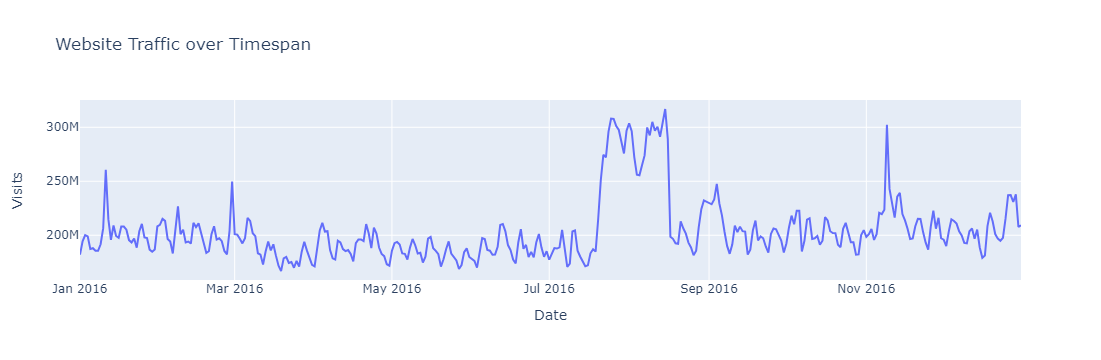

In [12]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=df['date'], y=df['visits'], mode='lines', name='Visits'))
fig.update_layout(title='Website Traffic over Timespan', xaxis_title='Date', yaxis_title='Visits')

fig.show()

#### Check for Trend

In [13]:
def rolling_mean_std(x, y, window_size):
    rolmean = y.rolling(window=window_size, min_periods=1).mean()
    rolstd = y.rolling(window=window_size, min_periods=1).std()

    fig = go.Figure()
    # Add traces for original, rolling mean, and rolling std
    fig.add_trace(go.Scatter(x=x, y=y, mode='lines', name='Original', line=dict(color='red')))
    fig.add_trace(go.Scatter(x=x, y=rolmean, mode='lines', name='Rolling Mean', line=dict(color='black')))
    fig.add_trace(go.Scatter(x=x, y=rolstd, mode='lines', name='Rolling Variance', line=dict(color='green')))
    
    # Update layout
    fig.update_layout(
        xaxis=dict(title='Date', tickformat="%b %Y"),
        yaxis=dict(title='Mean & Variance'),
        title='Rolling Mean & Standard Deviation of Website Traffic',
        legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1)
    )

    fig.show()

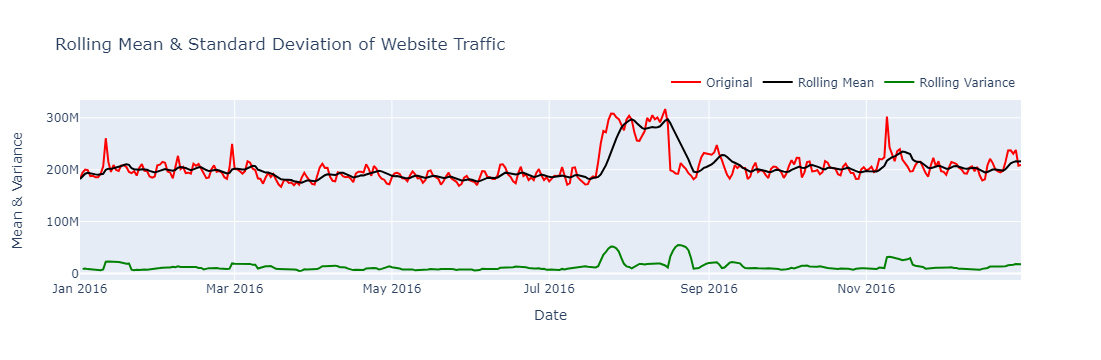

In [14]:
rolling_mean_std(x=df['date'], y=df['visits'], window_size=10)

#### Check for Seasonality

In [15]:
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import DecomposeResult, seasonal_decompose

def plot_seasonal_decompose(result:DecomposeResult, dates:pd.Series=None, title:str=""):
    x_values = dates if dates is not None else np.arange(len(result.observed))
    return (make_subplots(rows=4, cols=1, subplot_titles=["Observed", "Trend", "Seasonal", "Residuals"])
            .add_trace(go.Scatter(x=x_values, y=result.observed, mode="lines", name='Observed'),row=1, col=1)
            .add_trace(go.Scatter(x=x_values, y=result.trend, mode="lines", name='Trend'),row=2,col=1)
            .add_trace(go.Scatter(x=x_values, y=result.seasonal, mode="lines", name='Seasonal'),row=3,col=1)
            .add_trace(go.Scatter(x=x_values, y=result.resid, mode="lines", name='Residual'),row=4,col=1)
            .update_layout(height=900, title=f'<b>{title}</b>', margin={'t':100}, title_x=0.5, showlegend=False))

#### Additive Decomposition

Additive Time Series : Value = Base Level + Trend + Seasonality + Error

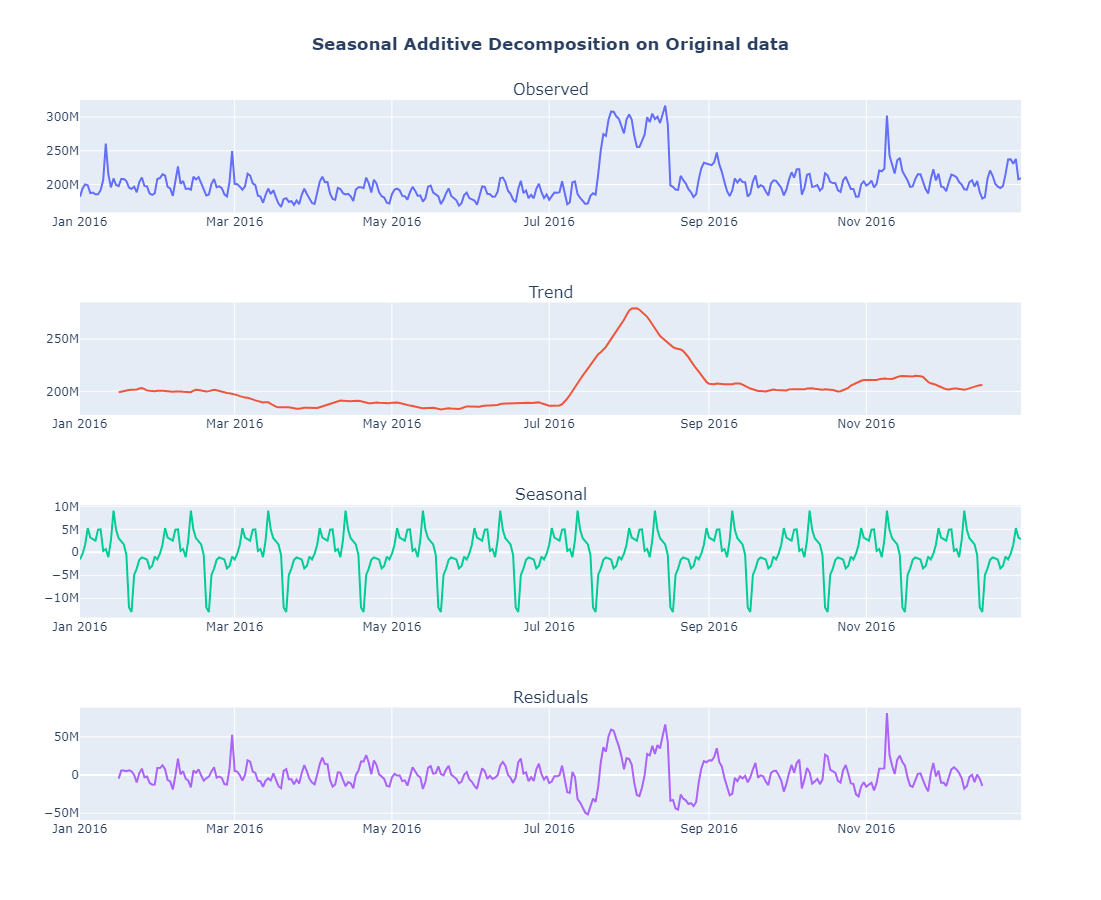

In [16]:
additive_decomposition = seasonal_decompose(df['visits'], model='additive', period=30)

plot_seasonal_decompose(additive_decomposition, 
                        title="Seasonal Additive Decomposition on Original data", 
                        dates = df['date']).show()

<!-- #### Multiplicative Decomposition 

Multiplicative Time Series : Value = Base Level x Trend x Seasonality x Error -->

#### Augmented Dickey-Fuller (ADF) Test:

In [17]:
from statsmodels.tsa.stattools import adfuller

def dickyFullerTest(x):  
    result = adfuller(x)
    print("ADF Statistics: %f" %result[0])
    print("p-value: %f" %result[1])
    
    print('Critical Value')
    for key, value in result[4].items():
        print('\t%s: %.3f'%(key, value))
        
    if result[1] > 0.05:
        print("Fail to reject null hypothesis(H0), the data is non-stationary.")
    else:
        print("Reject the null hypothesis(H0), the data is stationary.")

In [18]:
dickyFullerTest(df['visits'])

ADF Statistics: -2.640856
p-value: 0.084844
Critical Value
	1%: -3.449
	5%: -2.870
	10%: -2.571
Fail to reject null hypothesis(H0), the data is non-stationary.


### The data exhibits non-stationary behavior, and efforts are being made to transform it into a stationary state.

#### Differencing Method -- First Order Differencing (d = 1)

In [19]:
df['visits_diff_1'] = df['visits'].diff()

df.dropna(inplace=True)
df.head()

date       visits  visits_diff_1
185 2016-01-02  194359465.0     12342156.0
186 2016-01-03  200097562.0      5738097.0
187 2016-01-04  198959845.0     -1137717.0
188 2016-01-05  187263054.0    -11696791.0
189 2016-01-06  188006324.0       743270.0

#### Visualize the fist order differencing (d = 1) data

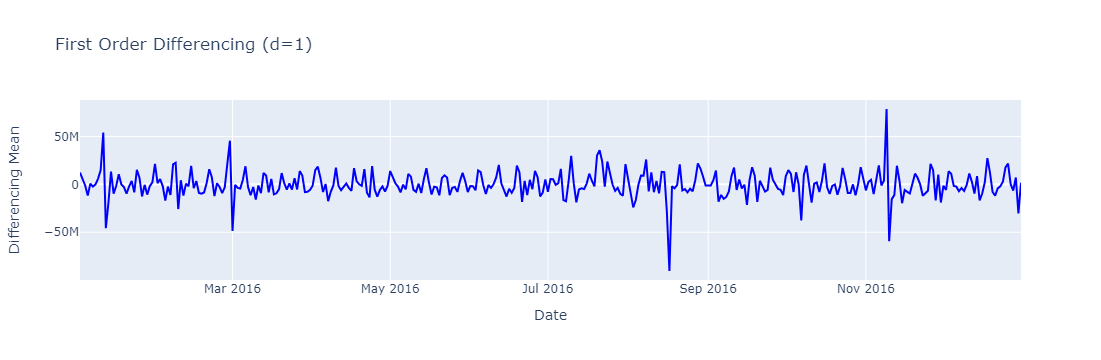

In [20]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df['date'], y=df['visits_diff_1'], mode='lines', line=dict(color='blue')))

fig.update_layout(
    title='First Order Differencing (d=1)',
    xaxis=dict(title='Date', tickformat="%b %Y"),
    yaxis=dict(title='Differencing Mean'),
)

fig.show()

#### Check for Trend for fist order differencing (d = 1) data

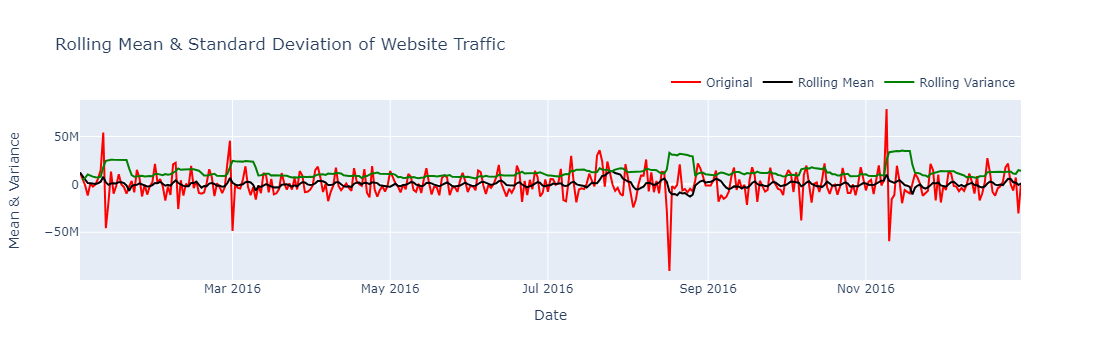

In [21]:
rolling_mean_std(x=df['date'], y=df['visits_diff_1'], window_size=10)

#### Check Seasonality for fist order differencing (d = 1) data

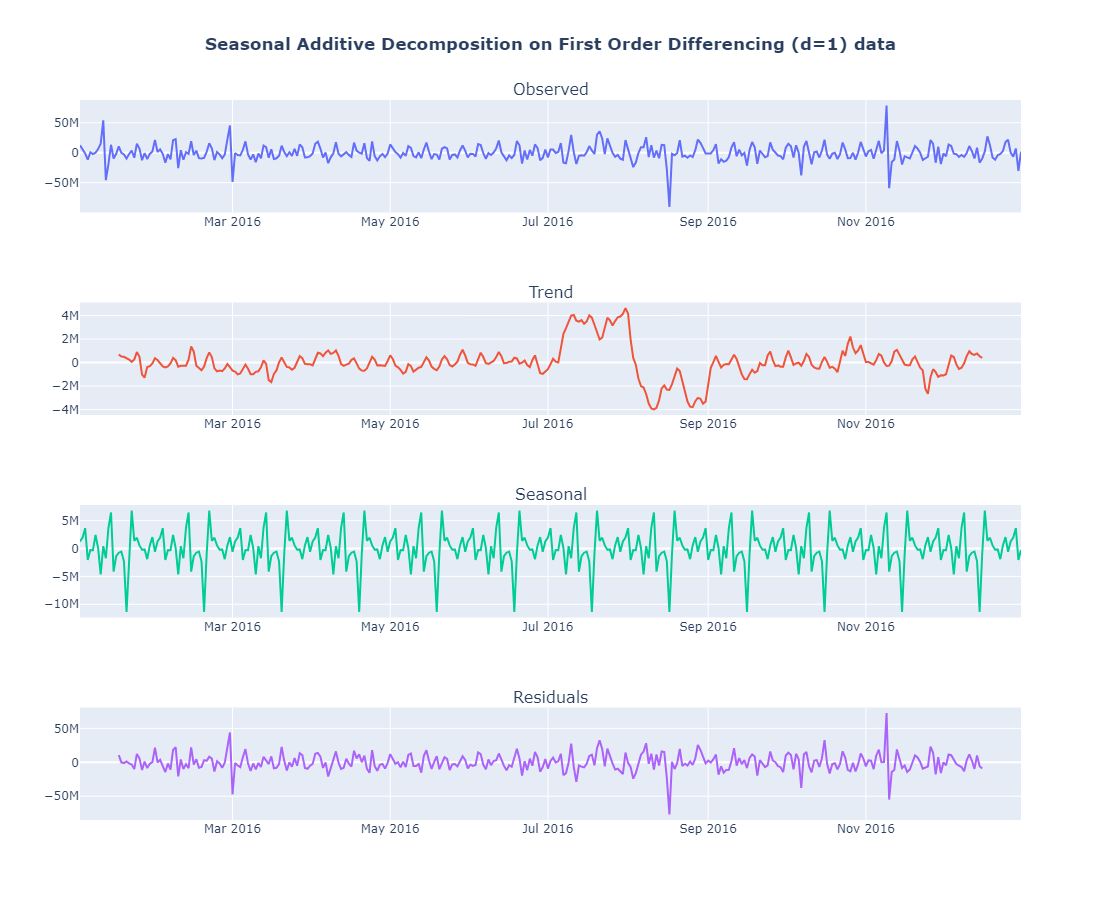

In [22]:
additive_decomposition = seasonal_decompose(df['visits_diff_1'], model='additive', period=30)

plot_seasonal_decompose(additive_decomposition, 
                        title="Seasonal Additive Decomposition on First Order Differencing (d=1) data", 
                        dates = df['date']).show()

#### The seasonal frequency (m) identified is 12, indicating a monthly-wise series.

#### Augmented Dickey-Fuller (ADF) Test

In [23]:
dickyFullerTest(df['visits_diff_1'])

ADF Statistics: -6.337131
p-value: 0.000000
Critical Value
	1%: -3.449
	5%: -2.870
	10%: -2.571
Reject the null hypothesis(H0), the data is stationary.


#### Web Traffic time series data is now turned to be Stationary.

#### Autocorrelation Analysis

In [24]:
from statsmodels.tsa.stattools import acf, pacf

def create_corr_plot(series, plot_pacf=False):
    corr_array = pacf(series.dropna(), alpha=0.05) if plot_pacf else acf(series.dropna(), alpha=0.05)
    
    lags = np.arange(len(corr_array[0]))
    autocorr_values = corr_array[0]
    conf_interv = corr_array[1]

    lower_y = conf_interv[:, 0] - autocorr_values
    upper_y = conf_interv[:, 1] - autocorr_values

    fig = go.Figure()
    fig.add_scatter(x=lags, y=autocorr_values, mode='markers', marker_color='#1f77b4', marker_size=12)

    for lag, autocorr_val in zip(lags, autocorr_values):
        fig.add_shape(type='line',
                      x0=lag, y0=0,
                      x1=lag, y1=autocorr_val,
                      line=dict(color='#3f3f3f'))

    # Plot the confidence intervals
    fig.add_scatter(x=lags, y=upper_y, mode='lines', line_color='rgba(255,255,255,0)')
    fig.add_scatter(x=lags, y=lower_y, mode='lines', fillcolor='rgba(32, 146, 230,0.3)',
                    fill='tonexty', line_color='rgba(255,255,255,0)')

    # Update layout
    fig.update_traces(showlegend=False)
    fig.update_xaxes(range=[-1, len(lags)])
    fig.update_yaxes(zerolinecolor='#000000')

    # Set the title
    title = 'Partial Autocorrelation (PACF)' if plot_pacf else 'Autocorrelation (ACF)'
    fig.update_layout(title=title)

    fig.show()

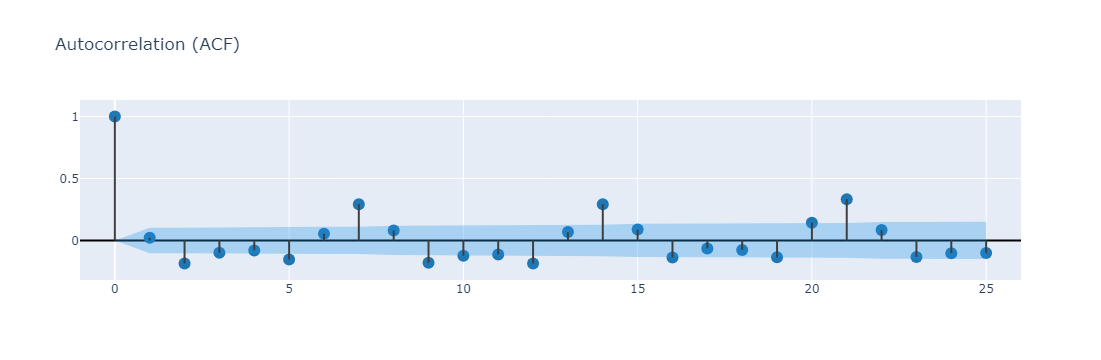

In [25]:
create_corr_plot(df['visits_diff_1'], plot_pacf=False)

#### q = 2, turned out to be most significant lag from above ACF plot.

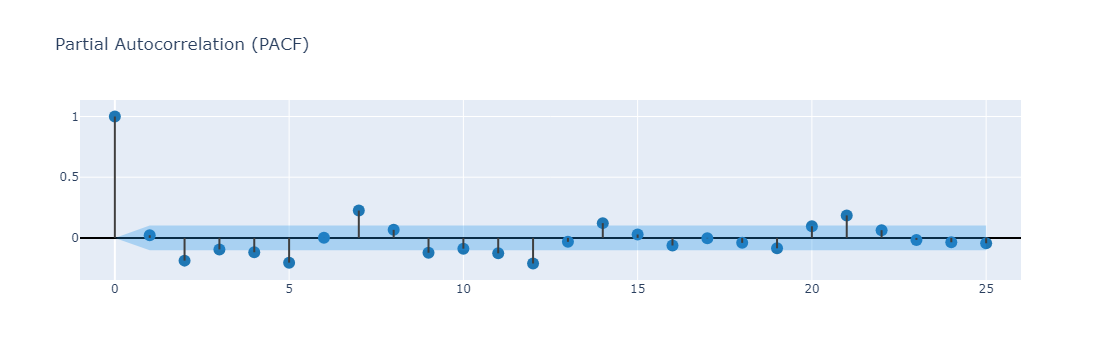

In [26]:
create_corr_plot(df['visits_diff_1'], plot_pacf=True)

#### p = 2, turned out to be most significant lag from above PACF plot.

#### Time Series Forecasting - ARIMA

In [27]:
import itertools
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

In [28]:
y = df.set_index("date")['visits'].copy()

y.index

DatetimeIndex(['2016-01-02', '2016-01-03', '2016-01-04', '2016-01-05',
               '2016-01-06', '2016-01-07', '2016-01-08', '2016-01-09',
               '2016-01-10', '2016-01-11',
               ...
               '2016-12-22', '2016-12-23', '2016-12-24', '2016-12-25',
               '2016-12-26', '2016-12-27', '2016-12-28', '2016-12-29',
               '2016-12-30', '2016-12-31'],
              dtype='datetime64[ns]', name='date', length=365, freq=None)

#### Fitting the ARIMA(p,d,q) model with order ARIMA(2, 1, 2) from above analysis.

In [29]:
arima_model = sm.tsa.ARIMA(y, order = (2, 1, 2))    # ARIMA(p,d,q)

results = arima_model.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2487      0.004    316.554      0.000       1.241       1.256
ar.L2         -0.9986      0.003   -340.056      0.000      -1.004      -0.993
ma.L1         -1.2394      0.020    -61.146      0.000      -1.279      -1.200
ma.L2          0.9974      0.033     30.280      0.000       0.933       1.062
sigma2      1.807e+14   1.99e-16    9.1e+29      0.000    1.81e+14    1.81e+14


In [30]:
pred = results.get_prediction(start=pd.to_datetime('2016-01-02'), dynamic=False)
pred_ci = pred.conf_int()

y_forecasted = pred.predicted_mean
y_truth = y['2016-01-02':]

mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 261592157080111.44


In [31]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 16173810.84


#### Also, Finding the best value for ARIMA(p,d,q)

In [32]:
p = range(0, 3)
d = range(1, 2)
q = range(0, 3)
pdq = list(itertools.product(p, d, q))

print('Examples of parameter combinations for ARIMA...')
for i in range(len(pdq)):
    print('ARIMA: {}'.format(pdq[i]))

Examples of parameter combinations for ARIMA...
ARIMA: (0, 1, 0)
ARIMA: (0, 1, 1)
ARIMA: (0, 1, 2)
ARIMA: (1, 1, 0)
ARIMA: (1, 1, 1)
ARIMA: (1, 1, 2)
ARIMA: (2, 1, 0)
ARIMA: (2, 1, 1)
ARIMA: (2, 1, 2)


In [33]:
# In ARIMA modeling, AIC stands for Akaike Information Criterion. It is a measure of the relative quality of a statistical model 
# for a given set of data. AIC provides a way to compare different models with different numbers of parameters, and choose 
# the one that best balances the trade-off between model fit and model complexity.

# The AIC value is calculated as:  AIC = 2k - 2ln(L)
# where k is the number of parameters in the model and L is the likelihood function of the model. 
# The AIC value is a scalar, and the lower the AIC value, the better the model is considered to fit the data.

# In ARIMA modeling, AIC is often used as a criterion for selecting the optimal values of the ARIMA parameters (p,d,q) 
# that provide the best fit to the data. The idea is to fit a range of ARIMA models with different parameter combinations, 
# and choose the one with the lowest AIC value as the best model.

best_param = None
min_aic = float('inf')

for param in pdq:
    try:
        model_arima = sm.tsa.ARIMA(y, order=param)
        model_arima_fit = model_arima.fit()
        
        current_aic = model_arima_fit.aic
        print('ARIMA{} - AIC:{}'.format(param, current_aic))
        
        # Update minimum AIC and corresponding parameters if the current model is better
        if current_aic < min_aic:
            min_aic = current_aic
            best_param = param

    except Exception as e:
        print(f'Error for order {param}: {e}')
        continue

ARIMA(0, 1, 0) - AIC:13011.268522097826
ARIMA(0, 1, 1) - AIC:13012.865388545795
ARIMA(0, 1, 2) - AIC:13005.394493766033
ARIMA(1, 1, 0) - AIC:13012.951084823228
ARIMA(1, 1, 1) - AIC:13006.142194397306
ARIMA(1, 1, 2) - AIC:13001.203281797129
ARIMA(2, 1, 0) - AIC:13006.219455704744
ARIMA(2, 1, 1) - AIC:13000.38726339147
ARIMA(2, 1, 2) - AIC:12948.089683272314


In [34]:
print('Best Model: ARIMA{} - Minimum AIC:{}'.format(best_param, min_aic))

Best Model: ARIMA(2, 1, 2) - Minimum AIC:12948.089683272314


In [35]:
arima_model = sm.tsa.ARIMA(y, order=best_param)

results = arima_model.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2487      0.004    316.554      0.000       1.241       1.256
ar.L2         -0.9986      0.003   -340.056      0.000      -1.004      -0.993
ma.L1         -1.2394      0.020    -61.146      0.000      -1.279      -1.200
ma.L2          0.9974      0.033     30.280      0.000       0.933       1.062
sigma2      1.807e+14   1.99e-16    9.1e+29      0.000    1.81e+14    1.81e+14


#### Interpret the Plot Diagnostics

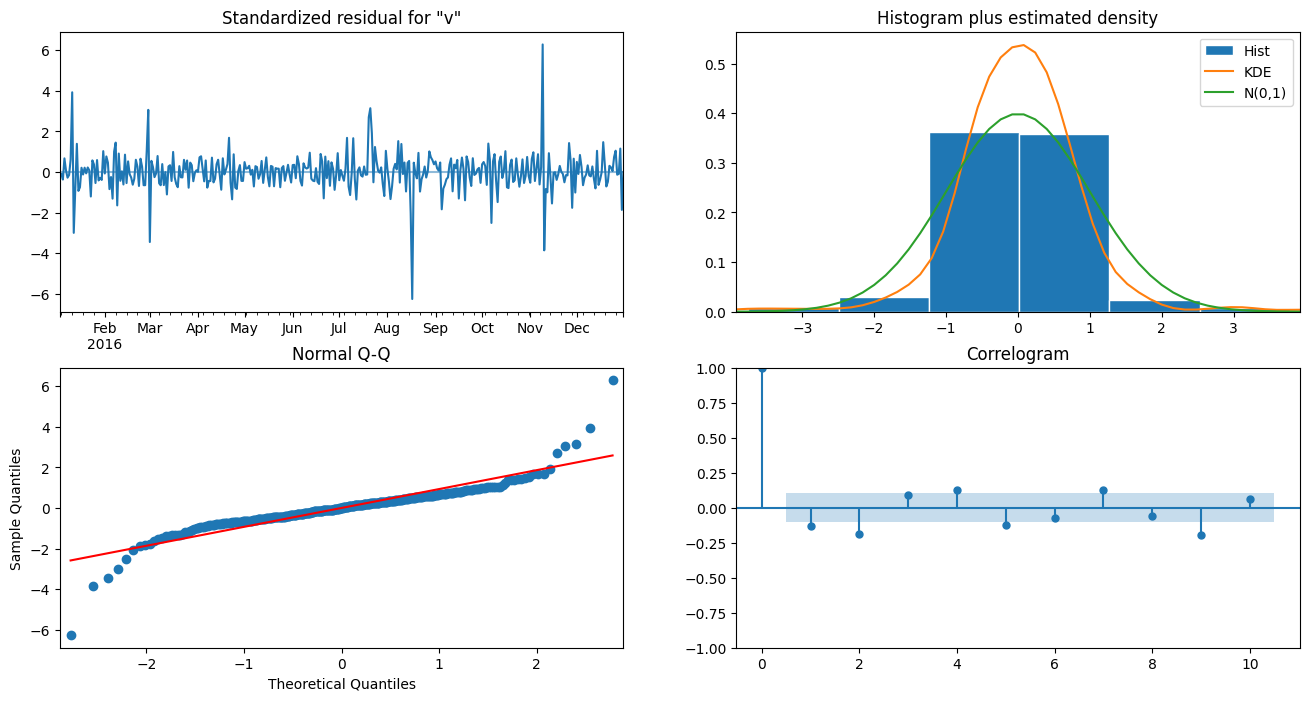

In [36]:
# Top left: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.
# Top Right: The density plot suggest normal distribution with mean zero.
# Bottom left: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.
# Bottom Right: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. 

results.plot_diagnostics(figsize=(16, 8)).show()

#### Validating forecast (Interpolation)

In [37]:
pred = results.get_prediction(start=pd.to_datetime('2016-01-02'), dynamic=False)
pred_ci = pred.conf_int()

y_forecasted = pred.predicted_mean
y_truth = y['2016-01-02':]

mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 261592157080111.44


In [38]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 16173810.84


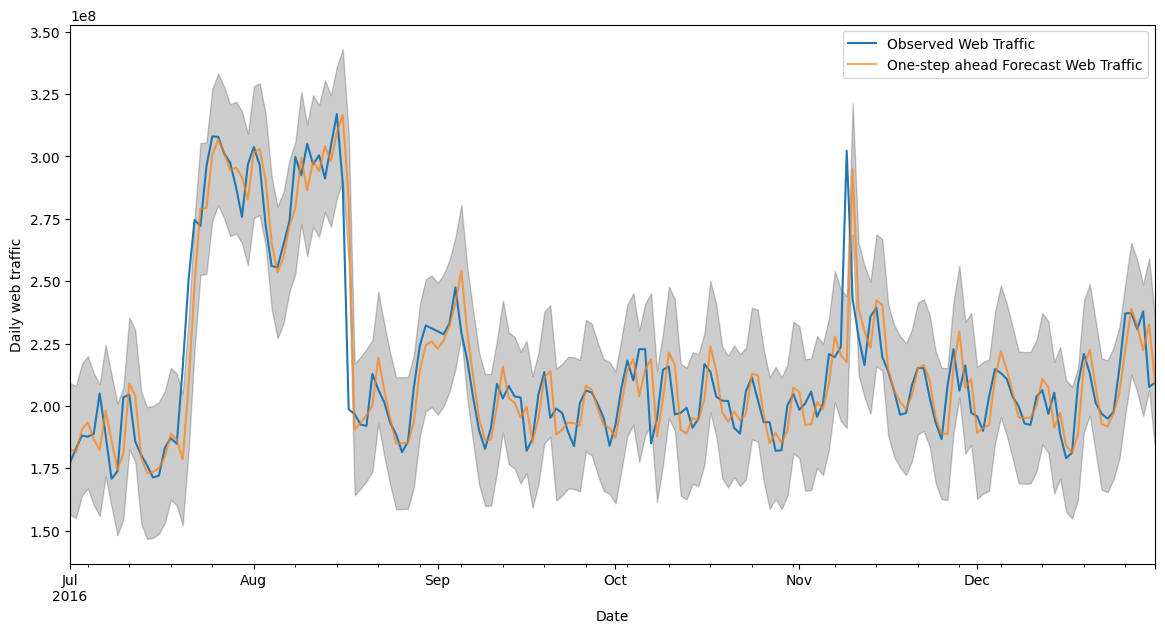

In [39]:
pred = results.get_prediction(start=pd.to_datetime('2016-07-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = y['2016-07-01':].plot(label='Observed Web Traffic')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast Web Traffic', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Daily web traffic')

plt.legend()
plt.show()

#### Producing and visualizing forecasts (Extrapolation)

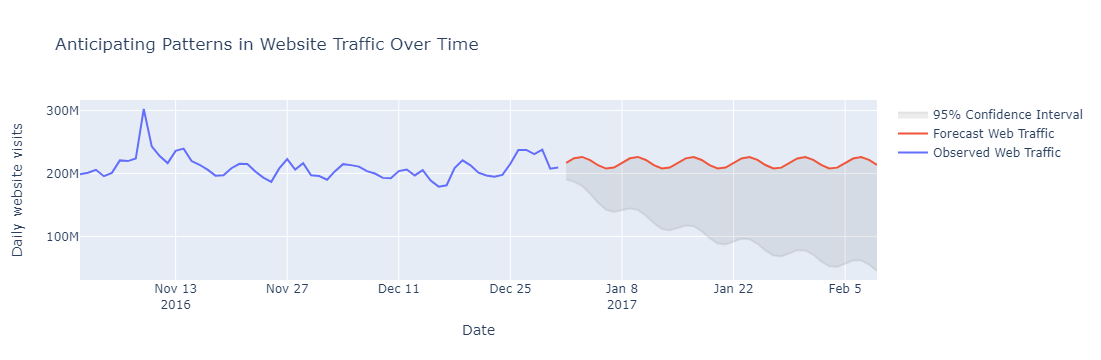

In [40]:
pred_uc = results.get_forecast(steps=40)
pred_ci = pred_uc.conf_int()

observed_trace = go.Scatter(x=y['2016-11-01':].index, y=y['2016-11-01':].values, mode='lines', name='Observed Web Traffic')
forecast_trace = go.Scatter(x=pred_uc.predicted_mean.index, y=pred_uc.predicted_mean.values, mode='lines', name='Forecast Web Traffic')

confidence_interval_trace = go.Scatter(x=pred_ci.index,
                                      y=pred_ci.iloc[:, 0],
                                      fill='tonexty',
                                      line=dict(color='rgba(68, 68, 68, 0.1)'),
                                      fillcolor='rgba(68, 68, 68, 0.1)',
                                      name='95% Confidence Interval')

layout = go.Layout(title='Anticipating Patterns in Website Traffic Over Time',
                   xaxis=dict(title='Date'),
                   yaxis=dict(title='Daily website visits'))

fig = go.Figure(data=[observed_trace, forecast_trace, confidence_interval_trace], layout=layout)

fig.show()

#### Time Series Forecasting - SARIMA

In [41]:
p = range(0, 3)
d = range(1, 2)
q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 1, 1) x (0, 1, 1, 12)
SARIMAX: (0, 1, 1) x (0, 1, 2, 12)
SARIMAX: (0, 1, 2) x (1, 1, 0, 12)
SARIMAX: (0, 1, 2) x (1, 1, 1, 12)


#### Fitting the SARIMA model

In [42]:
best_param = None
best_seasonal_param = None
min_aic = float('inf')

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            current_aic = results.aic
            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, current_aic))
            
            # Update minimum AIC and corresponding parameters if the current model is better
            if current_aic < min_aic:
                min_aic = current_aic
                best_param = param
                best_seasonal_param = param_seasonal
        except:
            continue


SARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:12846.060052889701
SARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:12226.501648249074
SARIMA(0, 1, 0)x(0, 1, 2, 12)12 - AIC:11772.523690160298
SARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:12325.343625401916
SARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:12208.284242474936
SARIMA(0, 1, 0)x(1, 1, 2, 12)12 - AIC:11760.029582166388
SARIMA(0, 1, 0)x(2, 1, 0, 12)12 - AIC:11816.614662039878
SARIMA(0, 1, 0)x(2, 1, 1, 12)12 - AIC:11784.179438873303
SARIMA(0, 1, 0)x(2, 1, 2, 12)12 - AIC:11747.1957079029
SARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:12811.0533930879
SARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:12225.807546729648
SARIMA(0, 1, 1)x(0, 1, 2, 12)12 - AIC:11777.831988841932
SARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:12342.430154746453
SARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:12219.971930236874
SARIMA(0, 1, 1)x(1, 1, 2, 12)12 - AIC:11779.830808048628
SARIMA(0, 1, 1)x(2, 1, 0, 12)12 - AIC:11865.521243758252
SARIMA(0, 1, 1)x(2, 1, 1, 12)12 - AIC:11847.831661429642
SARIMA(0, 1, 1)x(2, 1, 2, 12)12 - A

In [43]:
print('Best Model: SARIMA{}x{}12 - Minimum AIC:{}'.format(best_param, best_seasonal_param, min_aic))

Best Model: SARIMA(2, 1, 2)x(0, 1, 2, 12)12 - Minimum AIC:11707.078951105072


In [44]:
sarima_model = sm.tsa.statespace.SARIMAX(y,
                                order=best_param,
                                seasonal_order=best_seasonal_param,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = sarima_model.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2372      0.024     51.197      0.000       1.190       1.285
ar.L2         -0.9801      0.025    -39.078      0.000      -1.029      -0.931
ma.L1         -1.2456      0.035    -35.428      0.000      -1.315      -1.177
ma.L2          0.9325      0.044     21.190      0.000       0.846       1.019
ma.S.L12      -0.9212      0.105     -8.796      0.000      -1.126      -0.716
ma.S.L24       0.2445      0.099      2.467      0.014       0.050       0.439
sigma2      4.281e+14   7.86e-17   5.44e+30      0.000    4.28e+14    4.28e+14


#### Interpret the Plot Diagnostics

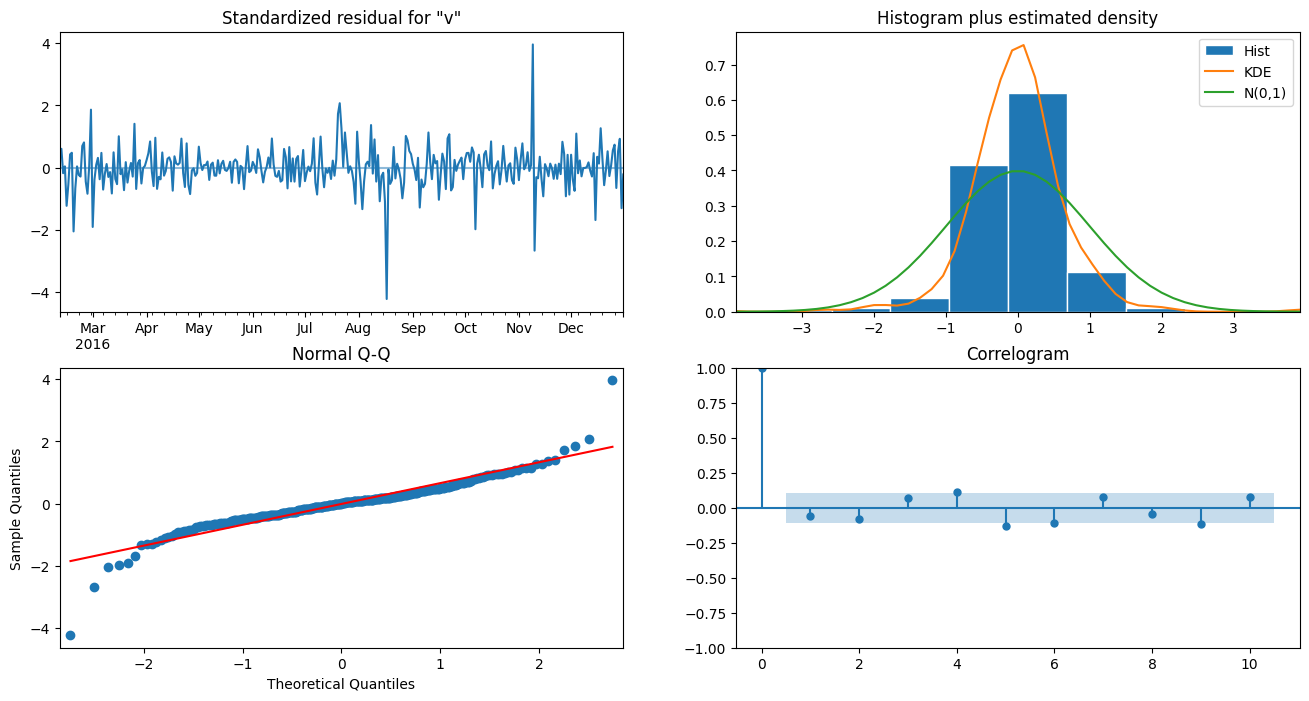

In [45]:
results.plot_diagnostics(figsize=(16, 8)).show()

#### Validating forecast (Interpolation)

In [46]:
pred = results.get_prediction(start=pd.to_datetime('2016-01-02'), dynamic=False)
pred_ci = pred.conf_int()

y_forecasted = pred.predicted_mean
y_truth = y['2016-01-02':]

mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 460239255099706.6


In [47]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 21453187.53


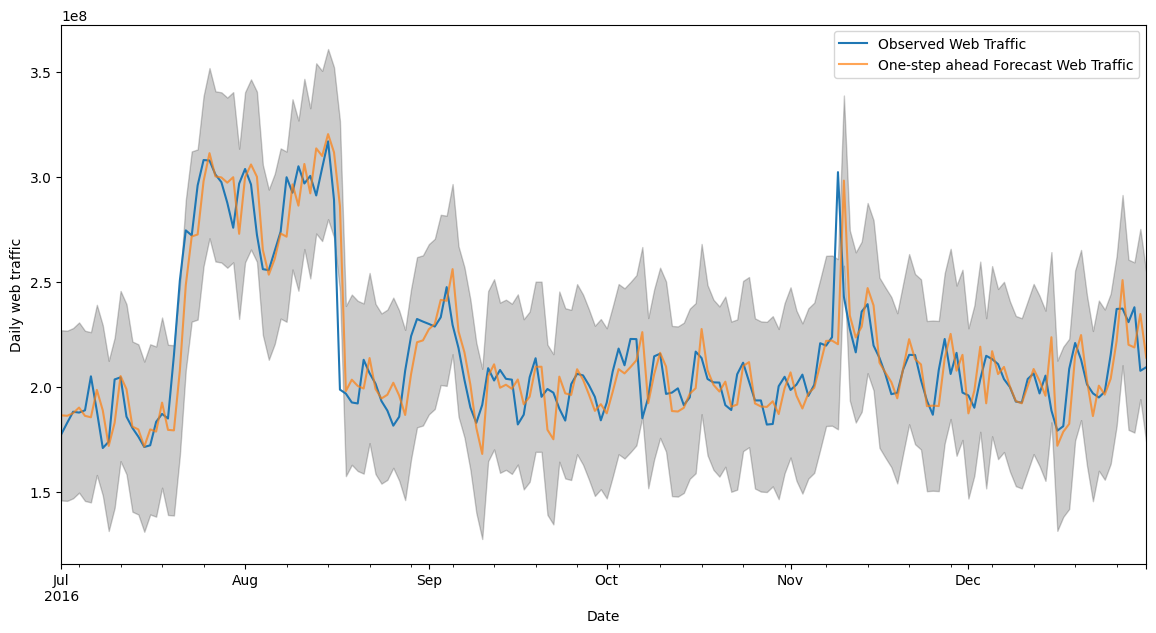

In [48]:
pred = results.get_prediction(start=pd.to_datetime('2016-07-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = y['2016-07-01':].plot(label='Observed Web Traffic')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast Web Traffic', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Daily web traffic')

plt.legend()
plt.show()

#### Producing and visualizing forecasts (Extrapolation)

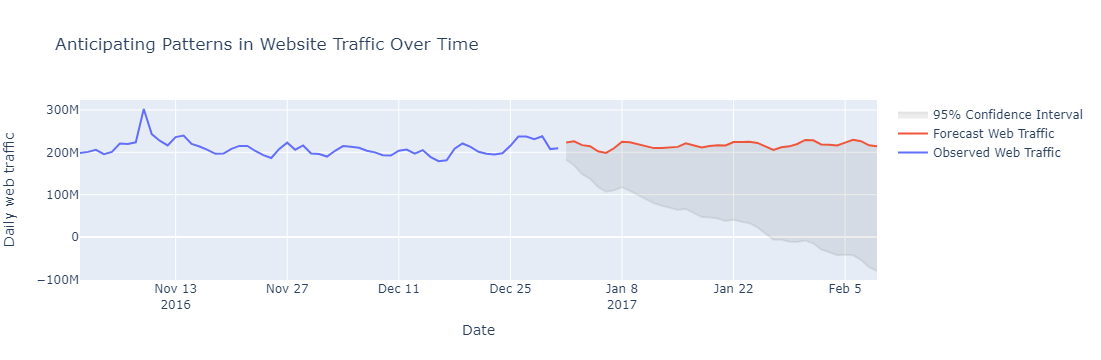

In [49]:
pred_uc = results.get_forecast(steps=40)
pred_ci = pred_uc.conf_int()

observed_trace = go.Scatter(x=y['2016-11-01':].index, y=y['2016-11-01':].values, mode='lines', name='Observed Web Traffic')
forecast_trace = go.Scatter(x=pred_uc.predicted_mean.index, y=pred_uc.predicted_mean.values, mode='lines', name='Forecast Web Traffic')

confidence_interval_trace = go.Scatter(x=pred_ci.index,
                                      y=pred_ci.iloc[:, 0],
                                      fill='tonexty',
                                      line=dict(color='rgba(68, 68, 68, 0.1)'),
                                      fillcolor='rgba(68, 68, 68, 0.1)',
                                      name='95% Confidence Interval')

layout = go.Layout(title='Anticipating Patterns in Website Traffic Over Time ',
                   xaxis=dict(title='Date'),
                   yaxis=dict(title='Daily web traffic'))

fig = go.Figure(data=[observed_trace, forecast_trace, confidence_interval_trace], layout=layout)

fig.show()